# Time series analysis

- Data from NASA/GSFC GIMMS NDVI3g version 1 1981-07-01 - 2015-12-31 1/12 x 1/12 degrees 1/24 a year.
- Only reggrided data (compatible with ERA-INTERIM grid).
- Methodology for anomalies decomposition.
- Testing unit roots for all pixels in South America.

## Initial setup

In [1]:
%load_ext autoreload
%autoreload 2  

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load packages.
import sys
import glob

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from scipy import stats
from dask.diagnostics import ProgressBar

from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler, RobustScaler

%matplotlib inline

In [4]:
print(">>> Version of xarray:", xr.__version__)

>>> Version of xarray: 0.14.0


In [5]:
# My repository.
repository = "/home/alex/Dropbox/repositories/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

# Map borders.
loni, lonf, lati, latf = -90, -30, 20, -60

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/"

In [6]:
# Folder with data.
DATA_FOLDER = "/media/alex/ALEXDATA/data_sets/GIMMS/"

In [7]:
# First we will use cartopy's shapereader to download (and cache) states shapefile with 50 
# meters resolution from the NaturalEarth.
kw = dict(resolution="50m", category="cultural", name="admin_1_states_provinces")
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

## Load data

In [8]:
# List files.
FILES_MMEANS = sorted(glob.glob(DATA_FOLDER + "NDVI_mmeans/*nc4"))

# DataSets objects.
DS = xr.open_mfdataset(FILES_MMEANS)

# South America.
DS = DS.sel(longitude=slice(loni, lonf), latitude=slice(lati, latf))

# Land mask at ERA-INTERIM grid.
DS = cdlearn.pixels.EraInterimGrid.add_land_mask(DS)

DS

<xarray.Dataset>
Dimensions:    (latitude: 107, longitude: 81, time: 414)
Coordinates:
  * longitude  (longitude) float64 -90.0 -89.25 -88.5 ... -31.5 -30.75 -30.0
  * latitude   (latitude) float64 19.5 18.75 18.0 17.25 ... -58.5 -59.25 -60.0
  * time       (time) datetime64[ns] 1981-07-01 1981-08-01 ... 2015-12-01
    land_mask  (latitude, longitude) bool True True True ... False False False
Data variables:
    ndvi       (time, latitude, longitude) float64 dask.array<chunksize=(6, 107, 81), meta=np.ndarray>

In [9]:
# Load data into memory.
DA = DS.ndvi
with ProgressBar():
    DA = DA.compute()

[########################################] | 100% Completed | 10.4s


In [10]:
%%time

# Anomalies.
DA_ano = cdlearn.statistics.anomalies(DA)

# Linear trends and its statistics.
trends, _ = cdlearn.statistics.linear_trends(DA)
linstats = cdlearn.statistics.linear_regression(DA)

# Climatology.
clim = cdlearn.statistics.climatology(DA)

CPU times: user 6.95 s, sys: 134 ms, total: 7.08 s
Wall time: 5.81 s


## Time series decomposition

* Proposed by Papagiannopoulou et al (2017):
 
The time series $y_t$ is linearly detrended over the entire period using:

$$
y_t^T = \alpha_0 + \alpha_1 t
$$

thus we obtain in this way the detrended time series $y_t^D$:

$$
y_t^D = y_t - y_t^T
$$

In a second step, after subtracting the trend from the raw time series, the seasonal cycle $y_t^S$ is calculated from $y_t^D$. Finally, the anomalies $y_t^A$ can then be computed by subtracting the corresponding monthly expectation from the detrended time series: 

$$
y_t^A = y_t^D - y_t^S
$$

CPU times: user 2.34 s, sys: 52 ms, total: 2.39 s
Wall time: 2.09 s


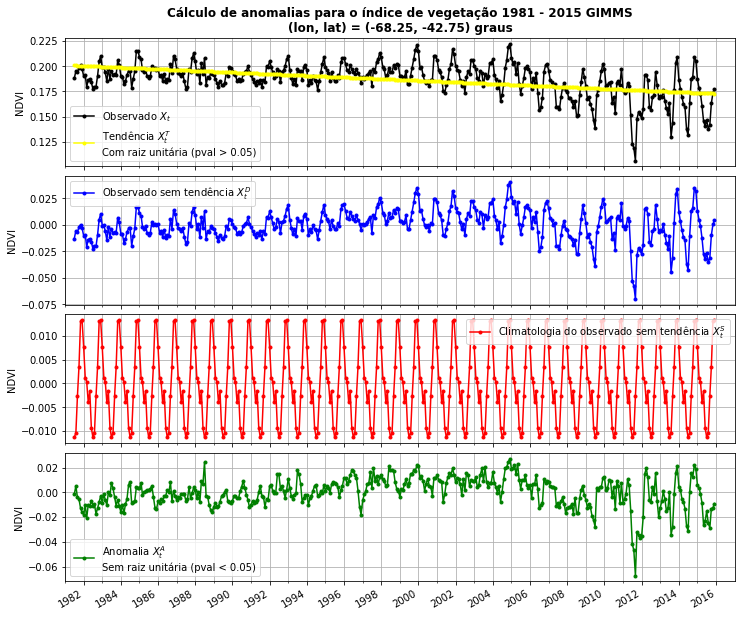

In [39]:
%%time

play = True

lon, lat = np.meshgrid(DA.longitude.values, DA.latitude.values)
lon = lon[DA.land_mask==True]; lat = lat[DA.land_mask==True]

if play:
    
    # Random land pixel.
    selection = {"longitude": np.random.choice(lon),
                 "latitude": np.random.choice(lat),
                 "method": "nearest"}    
    
else:    

    # Select a location around Manaus.
    selection = {"longitude": -60,
                 "latitude": -3,
                 "method": "nearest"}

# Complete and detailed example of anomaly calculation.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 10))

# Observed time series and its trend.
p_val = adfuller(DA.sel(**selection).values)[1]
if p_val <= 0.05:
    state = str("\nSem raiz unitária (pval < 0.05)")
else:
    state = str("\nCom raiz unitária (pval > 0.05)")
DA.sel(**selection).plot(ax=ax1, marker=".", color="black")
trends.sel(**selection).plot(ax=ax1, marker=".", color="yellow")
ax1.set_ylabel("NDVI"); ax1.set_xlabel(""); ax1.set_title("")
ax1.legend([r"Observado $X_t$", r"Tendência $X_t^T$" + state])
ax1.set_title("Cálculo de anomalias para o índice de vegetação 1981 - 2015" + \
              " GIMMS\n" + str("(lon, lat) = (%.2f, %.2f) graus" \
              %(selection["longitude"], selection["latitude"])), weight="bold")

# Detrend data.
(DA - trends).sel(**selection).plot(ax=ax2, marker=".", color="blue")
ax2.set_ylabel("NDVI"); ax2.set_xlabel(""); ax2.set_title("")
ax2.legend([r"Observado sem tendência $X_t^D$"])

# Climatology.
clim.sel(**selection).plot(ax=ax3, marker=".", color="red")
ax3.set_ylabel("NDVI"); ax3.set_xlabel(""); ax3.set_title("")
ax3.legend([r"Climatologia do observado sem tendência $X_t^S$"])

# Anomaly.
p_val = adfuller(DA_ano.sel(**selection).values)[1]
if p_val <= 0.05:
    state = str("\nSem raiz unitária (pval < 0.05)")
else:
    state = str("\nCom raiz unitária (pval > 0.05)")
DA_ano.sel(**selection).plot(ax=ax4, marker=".", color="green")
ax4.set_ylabel("NDVI"); ax4.set_xlabel(""); ax4.set_title("")
ax4.legend([r"Anomalia $X_t^A$" + state])

# Grids and axes.
for ax in [ax1, ax2, ax3, ax4]:
    years = mdates.YearLocator(2)
    years_fmt = mdates.DateFormatter("%Y")
    
    if ax == ax4:
        ax.set_xlim(pd.Timestamp("1981"), pd.Timestamp("2017"))
        ax.set_xticks(pd.date_range(start="1981", end="2016", freq="1YS"), minor=True)
    
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt) 
    ax.grid(which="both")
    
plt.subplots_adjust(hspace=0.075)    

# Save figure.
if play == True:
    plt.savefig(fig_path + "ndvi_gimms_anomaly_calculation_pt.jpg", 
                dpi=200, bbox_inches="tight")

## Testing if data is stationary

In [12]:
%%time

# Augmented Dickey-Fuller unit root test.
ADFs = cdlearn.statistics.unit_root_test(DA)
ADFs_ano = cdlearn.statistics.unit_root_test(DA_ano)

CPU times: user 6min 12s, sys: 3.53 s, total: 6min 15s
Wall time: 3min 8s


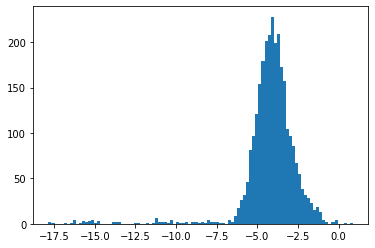

In [13]:
# Sanity check.
plt.hist(
    ADFs.sel(stats="adf_test").where(ADFs.land_mask==True).values.flatten(), 
    bins=100
);

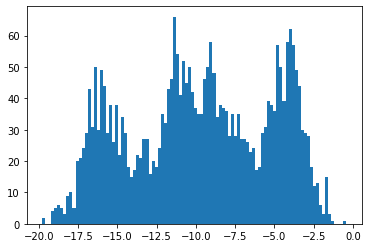

In [14]:

plt.hist(
    ADFs_ano.sel(stats="adf_test").where(ADFs_ano.land_mask==True).values.flatten(), 
    bins=100
);

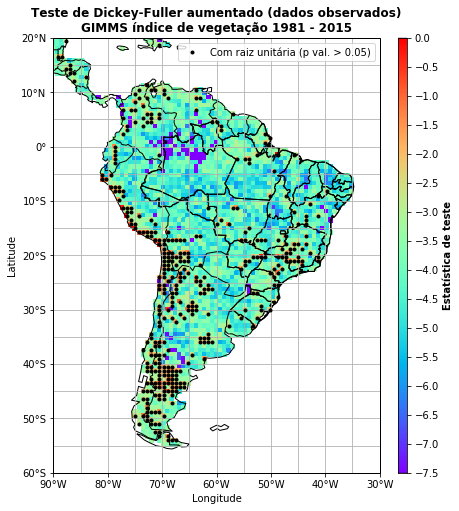

In [15]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(8, 8))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.02,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make map.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))

    # Plot data on this map.
    da = ADFs.sel(stats="adf_test").where(ADFs.land_mask == True)
    p = da.plot(
        ax=axis,
        vmin=-7.5,
        vmax=0,
        cmap=plt.cm.rainbow,
        add_colorbar=False,
        add_labels=False)
    
    # Labels.
    p.axes.set_xlabel("Longitude")
    p.axes.set_ylabel("Latitude")
    p.axes.set_title("Teste de Dickey-Fuller aumentado (dados observados)\n" + \
                     "GIMMS índice de vegetação 1981 - 2015", 
                     weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Estatística de teste", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-7.5, 0.5, 0.5))

# Statistical significant trends.
mask = ADFs.sel(stats="p_value").where(ADFs_ano.land_mask == True) > 0.05
LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

# With unit root.
axis.plot(LON[mask], LAT[mask], ".k", label="Com raiz unitária (p val. > 0.05)", 
          transform=projection)
   
# Legend.    
axis.legend() 
    
# Save figure.
plt.savefig(fig_path + "ndvi_gimms_adf_test_pt.jpg", dpi=200, bbox_inches="tight")

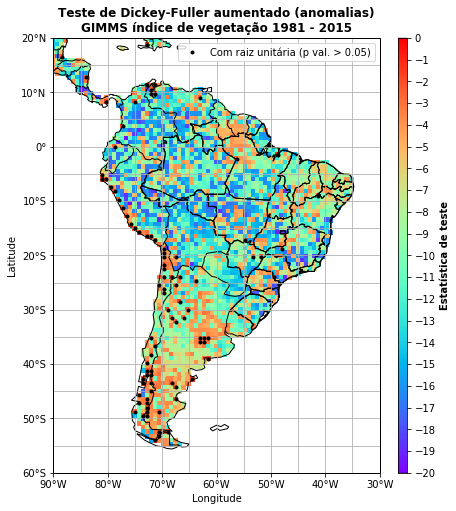

In [16]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(8, 8))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.02,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make map.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))

    # Plot data on this map.
    da = ADFs_ano.sel(stats="adf_test").where(ADFs_ano.land_mask == True)
    p = da.plot(
        ax=axis,
        vmin=-20,
        vmax=0,
        cmap=plt.cm.rainbow,
        add_colorbar=False,
        add_labels=False)
    
    # Labels.
    p.axes.set_xlabel("Longitude")
    p.axes.set_ylabel("Latitude")
    p.axes.set_title("Teste de Dickey-Fuller aumentado (anomalias)\n" + \
                     "GIMMS índice de vegetação 1981 - 2015", 
                     weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Estatística de teste", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-20, 1, 1))

# Statistical significant.
mask = ADFs_ano.sel(stats="p_value").where(ADFs_ano.land_mask == True) > 0.05
LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

# With unit root.
axis.plot(LON[mask], LAT[mask], ".k", label="Com raiz unitária (p val. > 0.05)", 
          transform=projection)
   
# Legend.    
axis.legend() 
    
# Save figure.
plt.savefig(fig_path + "ndvi_gimms_anomaly_adf_test_pt.jpg", dpi=200, bbox_inches="tight")